In [1]:
import math
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from ltn_imp.automation.knowledge_base import KnowledgeBase

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

In [4]:
from utils.custom_layers import *
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import utils.models as my_models
from utils.losses import weighted_binary_crossentropy_per_output
from utils.symmetric_net_utils import *
from utils.torch_model_manager import *
from utils.perturbation_strategies import *

In [5]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score, f1_score
from sklearn.model_selection import KFold
from sklearn.utils import class_weight

In [6]:
from psyki.logic import Theory
from psyki.logic.prolog import TuProlog
from psyki.ski import Injector

In [7]:
np.set_printoptions(precision=3, suppress=True)
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [8]:
X = pd.read_csv('./data/pima_indians_imputed.csv').astype(np.float32)
# X["DiabetesPedigreeFunction"] =  X["DiabetesPedigreeFunction"] * 100
# X["Pregnancies"] = X["Pregnancies"] * 10

dataset = X.copy()
# X = pd.read_csv('./data/diabetes.csv')
# y = X["Outcome"]
# X.drop(columns=["Outcome"],inplace=True)

y = X["Outcome"]
X.drop(columns=["Unnamed: 0","Outcome"],inplace=True)

In [9]:
zeros = sum(y==0)
ones = sum(y==1)

print("Class 0: ", zeros)
print("Class 1: ", ones)

unbalancement_index = abs(zeros - ones) / y.shape[0]
print(f"Unbalancement: {unbalancement_index}%")


Class 0:  500
Class 1:  268
Unbalancement: 0.3020833333333333%


In [10]:
#Normalization
scaler = MinMaxScaler()
X[X.columns] = scaler.fit_transform(X)

# Saving maxes
maxes = scaler.data_max_

In [11]:
# #TSNE to plot data
# tsne = TSNE(n_components=3, random_state=42)
# X_tsne = tsne.fit_transform(X)

# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')

# # Scatter plot 3D
# ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y, marker='o')

# # Etichette degli assi
# ax.set_xlabel('Asse X')
# ax.set_ylabel('Asse Y')
# ax.set_zlabel('Asse Z')

# plt.grid(True)
# plt.show()

In [12]:
# Null count
null_counts_per_row = X.isnull().sum(axis=0)

null_counts_per_row

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

In [13]:
cw = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
class_0_weight = cw[0]
class_1_weight = cw[1]

In [ ]:
layers_number = 2
units = 12

input_shape = (X.shape[1:])
EPOCHS = 100

n_splits = 4

tests_info = { # name : [learning_rate]
    "Uneducated":[0.001],
    "KBANN":[0.0001],
    "KINS":[0.01],
    "LTN":[0.001],
    "Symmetric":[0.001]
}

perturbation_strategies_info = {
    "None" : (None,[1]),
    "Label Flipping": (label_fliping, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]),
    "Feature Noise": (feature_noise, [1, 2, 3, 4, 5, 6, 7]),
    "Feature Corruption": (feature_corruption, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])    
}

In [15]:
knowledge = TuProlog.from_file("./knowledge/diabetes.pl")
theory = Theory(knowledge, dataset)
for rule in theory.formulae:
    print(f"{rule.rhs} -> {rule.lhs.args.last}")

Glucose > 126.0, BMI > 30.0 -> 1.0
Glucose =< 100.0, BMI =< 25.0 -> 0.0


In [ ]:
# This map will contain performances foreach tested model
test_performances = {}
perturbation_results = {}

# KFold for cross validation
kf = KFold(
    n_splits=n_splits,
    # random_state=42
)

# Iterating test infos
for current_test_name, current_test_params  in tests_info.items():  
    for perturbation_name, (perturbation_function,perturbation_params)  in perturbation_strategies_info.items():  
        for perturbation_entity in perturbation_params:
            all_score = []


            specificity_knowledge = 0
            recall_knowledge = 0

            sp_kn_count = 0
            re_kn_count = 0

            # Cross validation
            for train_index, val_index in kf.split(X):
                early_stopping = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)
                
                optimizer = tf.keras.optimizers.Adam(
                    learning_rate=current_test_params[0],
                )
                
                
                # Subdividing dataset in training and validation fold
                train = dataset.iloc[train_index,:]
                X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                
                if(perturbation_name!="None"):
                    X_train, y_train = perturbation_function(X_train, y_train, perturbation_entity)

                # Computing class weight
                cw = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_val), y=y_val)
                class_0_weight = cw[0]
                class_1_weight = cw[1]

                # Initializing base model
                uneducated = my_models.getBaseModel(
                    input_shape,
                    units,
                    layers_number,
                )
                
                sample_weight = ((y_train == 1) * class_1_weight) + ((y_train == 0) * class_0_weight)

                if current_test_name != "LTN":
                    # Tensorflow based algorithms

                    output_weights = [1]

                    if current_test_name == "Uneducated" or current_test_name == "Symmetric":
                        model = uneducated                
                    else:
                        theory = Theory(knowledge, train)
                        theory.set_all_formulae_trainable()

                        if current_test_name == "KBANN":
                            injector = Injector.kbann(uneducated)

                            # Adapting target to KBANN structure
                            output_weights = [1, 1]
                            y_train = np.column_stack([y_train.copy(), 1-y_train])
                            y_val = np.column_stack([y_val.copy(), 1-y_val])

                        elif current_test_name == "KINS":
                            injector = Injector.kins(uneducated)

                        # Injecting knowledge
                        model = injector.inject(theory)

                    # plot_model(model, to_file='educated_structure.png', show_shapes=True, show_layer_names=True)
                    # 1/
                    
                    epochs = EPOCHS

                    if current_test_name == "Symmetric":
                        epochs = epochs // 2

                    #####################################
                    # Compile and train selected model
                    model.compile(
                        optimizer = optimizer,
                        loss=weighted_binary_crossentropy_per_output(output_weights),
                        metrics=['accuracy'],            
                    )

                    model.fit(
                        X_train,
                        y_train,
                        sample_weight=sample_weight,
                        batch_size=32,
                        epochs=epochs,
                        callbacks=[early_stopping]
                    )
                    #####################################

                    if current_test_name == "Symmetric":
                        output_weights = [class_0_weight,class_1_weight*1.6,3.8,0.9]

                        # Initializing symmetric model
                        symmetric = my_models.getQuadModel(
                            input_shape,
                            model,                    
                        )       

                        # Creating mask and preparing data for symmetric model training
                        mask = get_mask(X_train,y_train, maxes)            
                        x_symmetric, y_symmetric, sample_weight = create_4_tuple(X_train, y_train, mask)

                        #################################
                        #Compiling and training symmetric model

                        symmetric.compile(
                            optimizer = optimizer,  
                            loss=weighted_binary_crossentropy_per_output(output_weights), 
                            metrics=['accuracy']
                        )

                        symmetric.fit(
                            x_symmetric,
                            y_symmetric,
                            sample_weight=sample_weight,
                            batch_size=32,
                            epochs=EPOCHS//2,
                            # class_weight={0:[cw[0],1,1],1:[cw[1],1,1]},
                            callbacks=[early_stopping]
                        )
                        ###############################

                    # Prediction on validation set    
                    prediction = model.predict(X_val)

                    if current_test_name == "KBANN":
                        # Transforming y to single value target
                        y_val = y_val[:,0]
                        prediction = prediction[:,0]
                else:
                    #LTN
                    # caching datasets
                    X_train_tosave = X_train.copy()
                    X_val_tosave = X_val.copy()

                    X_train_tosave["Outcome"] = y_train
                    X_val_tosave["Outcome"] = y_val

                    cache_datasets({
                        "train": X_train_tosave,
                        "test":X_val_tosave,
                        "val":X_val_tosave
                    })

                    # Creating LTN model
                    kb = KnowledgeBase("./knowledge/config.yaml")
                    model = kb.predicates["Diabetic"]

                    train_model(model, kb, lr=current_test_params[0])

                    prediction = predict(model, X_val.to_numpy())


                # Preparing data to evaluate model recall and specificity on knowledge elements
                knowledge_mask = get_mask(X_val, y_val, maxes)
                target_0_knowledge = y_val[knowledge_mask & (y_val==0)]
                prediction_on_target_0 = prediction[knowledge_mask & (y_val==0)]>0.5
                target_1_knowledge = y_val[knowledge_mask & (y_val==1)]
                prediction_on_target_1 = prediction[knowledge_mask & (y_val==1)]>0.5
                

                all_score.append([
                    accuracy_score(y_val, prediction>0.5), # accuracy
                    balanced_accuracy_score(y_val, prediction>0.5), # balanced accuracy
                    recall_score(y_val, prediction>0.5), # recall
                    recall_score(y_val == 0, prediction<0.5), # recall on 0
                    f1_score(y_val, prediction>0.5), # f1score
                ])

                ######
                # Evaluating model recall and specificity on knowledge elements
                if(len(target_0_knowledge) > 0 and len(prediction_on_target_0)>0):
                    specificity_knowledge += accuracy_score(target_0_knowledge, prediction_on_target_0)
                    sp_kn_count += 1

                if(len(target_1_knowledge) > 0 and len(prediction_on_target_1)>0):
                    recall_knowledge += accuracy_score(target_1_knowledge, prediction_on_target_1)
                    re_kn_count += 1
                ######

            all_score = np.sum(np.array(all_score), axis=0)
            all_score = all_score / n_splits

            specificity_knowledge /= sp_kn_count
            recall_knowledge /= re_kn_count

            all_score=np.append(all_score, specificity_knowledge)
            all_score=np.append(all_score, recall_knowledge)

            if(perturbation_name == "None"):
                test_performances[current_test_name] = all_score
            else:
                new_perturbation_result_key = current_test_name+"("+perturbation_name+")"
                if new_perturbation_result_key in perturbation_results:
                    perturbation_results[new_perturbation_result_key][perturbation_entity] = all_score
                else:
                    perturbation_results[new_perturbation_result_key] = {perturbation_entity:all_score}


Epoch 1/100
18/18 [==============================] - 1s 3ms/step - loss: 0.6888 - accuracy: 0.5000
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 0.6817 - accuracy: 0.5660
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 0.6765 - accuracy: 0.6181
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6706 - accuracy: 0.6597
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 0.6656 - accuracy: 0.6580
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6753
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 0.6566 - accuracy: 0.6927
Epoch 8/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.6944
Epoch 9/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6467 - accuracy: 0.7014
Epoch 10/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6411 - accuracy: 0.6979
Epoch 11

In [ ]:
# pd.DataFrame(perturbation_results).to_csv("perturbation_results.csv")

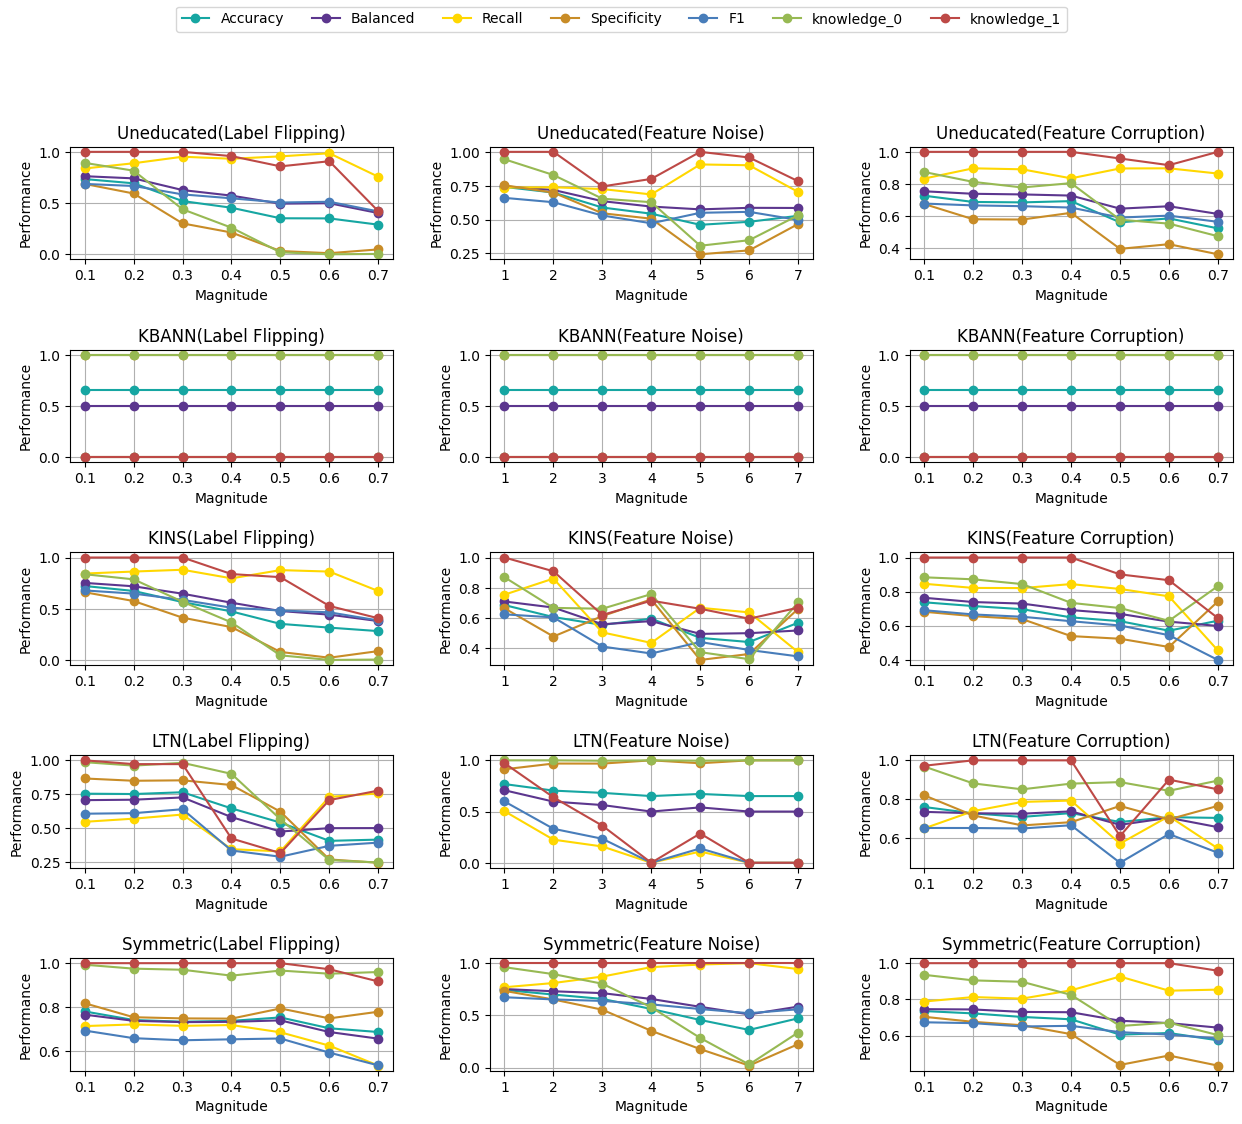

In [57]:
metrics = ["Accuracy", "Balanced", "Recall", "Specificity", "F1", "knowledge_0", "knowledge_1"]

plots_count = len(perturbation_results.keys())
columns = min(len(perturbation_strategies_info) - 1, plots_count)
rows = math.ceil(plots_count / columns)

fig, axes = plt.subplots(rows, columns, figsize=(15, 12)) 
axes = np.array(axes).reshape(rows, columns)  

colors = ["#16A6A2", "#5C368E", "gold", "#C88C27", "#487DBA", "#97B953", "#BD4946"]
styles = [     "-",       "-",    "-",      "-",       "-",      "-",      "-"]

for i, (perturbation, results) in enumerate(perturbation_results.items()):
    x_plot = results.keys()
    y_plot = list(results.values())
    y_plot = np.stack(y_plot)  

    ax = axes[i // columns][i % columns] if plots_count > 1 else axes

    ax.set_title(perturbation)
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Performance')

    for j, metric in enumerate(metrics):
        ax.plot(x_plot, y_plot[:, j], marker='o', label=metric, color=colors[j], linestyle=styles[j])
    
    ax.grid(True)

handles = [plt.Line2D([0], [0], color=colors[i], marker='o', linestyle=styles[i], label=metric) for i, metric in enumerate(metrics)]
fig.legend(handles, metrics, loc='upper center', ncol=len(metrics))

plt.subplots_adjust(hspace=0.8, wspace=0.3)

In [22]:
# Plotting performances table
table = pd.DataFrame(test_performances)

metrics = ["Accuracy", "Balanced", "Recall", "Specificity", "F1","knowledge_0", "knowledge_1"]

data = []
for model, values in test_performances.items():
    row = np.append(np.array([model]), values)
    data.append(row)

columns = ["Model"] + metrics
table = pd.DataFrame(data, columns=columns)
table


Model            Accuracy            Balanced              Recall  \
0  Uneducated  0.7630208333333333  0.7606841333350165  0.7455252672287775   
1       KBANN  0.6510416666666666                 0.5                 0.0   
2        KINS  0.7565104166666666  0.7500346524796611  0.7393969696595879   
3         LTN  0.7708333333333334  0.7253471813199173  0.5756368978229002   
4   Symmetric  0.7669270833333334   0.758978083918852   0.733081010565791   

          Specificity                  F1         knowledge_0 knowledge_1  
0  0.7758429994412555  0.6860593971631205  0.9752508055324957         1.0  
1                 1.0                 0.0                 1.0         0.0  
2  0.7606723352997344  0.6790363135394272  0.9599168437196606         1.0  
3  0.8750574648169344  0.6361421670117322  0.9923076923076923         1.0  
4   0.784875157271913  0.6856333645188607  0.9822930590536225         1.0